#**Battle of the Neighborhoods**
##IBM Data Science Capstone Project (IBM Data Science Professional Certificate)
____

>I am going to analyse the COVID-19 cases in the United States of America using:
- Kaggle dataset - [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/version/69). 
- [Foursquare](https://foursquare.com/) API
- [Scikit-learn](https://scikit-learn.org/) Package.
- [Folium](https://python-visualization.github.io/folium/) Package.

>Using the data from the aforementioned Kaggle dataset, I am going to cluster the COVID-19 cases in the US using a K-NN clustering algorithm from SKLearn Package and then plot it on a map using the Folium Package.

____

**Importing all the required packages for the project.**

In [1]:
# Dataframe package
import pandas as pd

# Machine Learning package
from sklearn.cluster import KMeans

# Web scraping packages
from bs4 import BeautifulSoup
import requests

# Visualization packages
from matplotlib import pyplot as plt
import seaborn as sns
import folium

# Linear Algebra package
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Reading the dataset from a csv file as a dataframe
df = pd.read_csv('covid_19_data.csv')

# Renaming the columns to a better, smaller name
df.rename(columns={
    'Province/State': 'State',
    'Country/Region': 'Country',
}, inplace=True)

# Printing the first 5 rows of the dataframe
print(f'The number of rows in the dataframe is {len(df)}.')
df.head()

The number of rows in the dataframe is 16729.


,SNo,ObservationDate,State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


**Dropping unnecessary columns and rows**

As we can see from the above output, the dataframe has the following columns:
- SNo
- ObservationDate
- Province/State
- Country
- Lasy Update
- Confirmed
- Deaths
- Recovered

From these features, only State, Country and Confirmed are required for our project. So all other columns are dropped from the dataframe and moreover, only the rows where the Country is US is retained.

In [3]:
# Only keeping the columns that we need
df = df[['State', 'Country', 'Confirmed']]

# Only keeping the rows that have the country as US
df = df[df['Country'] == 'US']

# Printing the first 5 rows of the dataframe
print(f'The number of rows in the dataframe is {len(df)}.')
df = df.reset_index(drop=True)
df.head()

The number of rows in the dataframe is 3250.


,State,Country,Confirmed
0,Washington,US,1.0
1,Washington,US,1.0
2,Washington,US,1.0
3,Chicago,US,1.0
4,Washington,US,1.0


In [4]:
values = set()
for value in df['State'].values:
  values.add(value)

print(f'The number of states in the dataframe is {len(values)}')

The number of states in the dataframe is 199


**Web scraping the list of US states and their abbreviations from the wikipedia page.**

As we can see from the above output, there are a total of 199 states in the dataframe. But we know that there are only 50 US states. Therefore, let's correctly map the data using a list of all US states and their abbreviations.

In [0]:
# Getting the webpage from the url using requests package
website_url = "https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States"
webpage = requests.get(website_url).text

# This function retrieves the raw data from the webpage
soup = BeautifulSoup(webpage, 'lxml')

# Retrieving the specific table that contains the data that we require
table = soup.find('table', {
    'class': 'wikitable sortable plainrowheaders'
})

In [6]:
# Retrieving all the <tr> tags from the soup
# Each of these tags will represent a row in our DataFrame
rows = table.find('tbody').find_all('tr')[2:]

# Populating an array with the states values from the rows
states = []
for row in rows:
  state = []
  # The state abbreviation
  state.append(row.find('td').contents[0].rstrip())

  # The state name
  state.append(row.find('th').find('a').contents[0].rstrip())
  states.append(state)

# The length of the states array
print(f'There are {len(states)} states in the US.')

There are 50 states in the US.


**Replacing all the wrong values of the states in the dataframe to the correct values.**

After doing this, we should have a dataframe with 50 rows, one for each state.

In [7]:
# Creating a new dataframe with just the state and the most recent confirmed cases count
states_df = pd.DataFrame(columns=['State', 'StateName', 'Confirmed'])

# Iterating over each state in states and getting the data from the df dataframe and appending to states_df dataframe
for state in states:
  # Getting rows which have either the state name or the state abbreviation
  val = df[df['State'].str.contains(state[1]) | df['State'].str.contains(state[0])].values[-1]
  # Creating a pandas Series with the data
  row = pd.Series([state[0], state[1], val[2]], index=states_df.columns)
  
  # appending the row to the states_df dataframe
  states_df = states_df.append(row, ignore_index=True)

# Printing the first 5 rows of the dataframe
print(f'The number of rows in the states_df dataframe is {len(states_df)}.')
states_df.head()

The number of rows in the states_df dataframe is 50.


,State,StateName,Confirmed
0,AL,Alabama,4888.0
1,AK,Alaska,319.0
2,AZ,Arizona,4933.0
3,AR,Arkansas,1781.0
4,CA,California,31431.0


**Exploratory analysis of the COVID-19 cases per state**

By plotting a few graphs, we will be able to better understand the situation in each state.

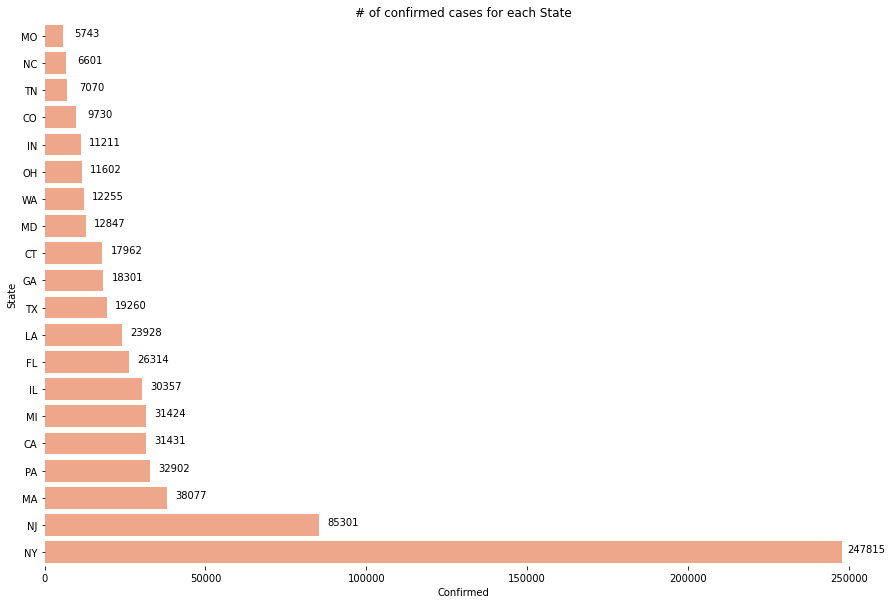

In [8]:
bar_data = states_df[['State', 'Confirmed']]
bar_data = bar_data.sort_values(by=['Confirmed'])
bar_data = bar_data.reset_index(drop=True)

# Exploring the top 20 states of US by confirmed cases
bar_data = bar_data[-20:]

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title("# of confirmed cases for each State")

sns.set_color_codes()
graph = sns.barplot(x="Confirmed", y="State", data=bar_data, label="Total", color="lightsalmon")
sns.despine(left=True, bottom=True)

for index, row in bar_data.iterrows():
    graph.text(row['Confirmed'] + 7500, index - 30, '%d'%row['Confirmed'], color='black', ha="center")

plt.show()

From the above graph, we can see that New York has almost 3 times as many cases as New Jersey (which has the second most number of confirmed cases). This is an astounding fact but it is justified by the fact that the population density of NY is almost **22 times** that of NJ!!

Moreover, NYC is one of the top tourist destinations of the US and it has the highest influx of foreign population from various foreign countries. 

**Using the Foursquare API to get the location data of each US state**

In [0]:
# Setting up the credentials for foursquare API
CLIENT_ID = "WCSYXZ1P1OBG5ANAIMZFIOYFJURWNPLKZY0A0DQGTV5CEO1J"
CLIENT_SECRET = "CAQPZAEQBRYSFBXIJCYAUTX4K55TXHPQIVPANEZ5UGPAXURL"
VERSION = "20200420"

In [0]:
lat = []
lng = []

# Getting the latitude and longitude for each state in states_df
for row in states_df.values:
  state_name = row[1]
  API_CALL = f"https://api.foursquare.com/v2/venues/search?near={state_name}&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&limit=1&v={VERSION}"
  res = requests.get(API_CALL)
  lat.append(res.json()['response']['geocode']['feature']['geometry']['center']['lat'])
  lng.append(res.json()['response']['geocode']['feature']['geometry']['center']['lng'])

In [11]:
# Setting the latitude and longitude for each state
states_df['Lat'] = lat
states_df['Lng'] = lng

# Printing the first 5 rows of states_df
states_df.head()

,State,StateName,Confirmed,Lat,Lng
0,AL,Alabama,4888.0,32.75041,-86.75026
1,AK,Alaska,319.0,64.00028,-150.00028
2,AZ,Arizona,4933.0,34.50030,-111.50098
3,AR,Arkansas,1781.0,34.75037,-92.50044
4,CA,California,31431.0,37.25022,-119.75126


**Visualizing the number of cases in each US State using Folium**

We can plot a Folium Map with CircleMarkers with radius proportional to the number of confirmed cases.

In [0]:
in_min = min(states_df['Confirmed'])
in_max = max(states_df['Confirmed'])
out_min = 25
out_max = 100

def map_radii(cases):
  slope = (out_max - out_min) / (in_max - in_min)
  return out_min + slope * (cases - in_min)

In [13]:
USMap = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

for row in states_df.values:
  lat, lng = row[-2], row[-1]
  cases = row[2]

  folium.CircleMarker([lat, lng], 
                      radius=map_radii(cases),
                      color='#85144b',
                      fill_color='#FF4136',
                      fill_opacity=0.2,
                      weight=0.6
  ).add_to(USMap)

USMap

As we can see from the above map, the most number of cases are from the east coast of the US. 

**Using a KNN clustering algorithm**

In [14]:
# The input to the clustering algorithm
X = []

for row in states_df.values: 
  for i in range(int(row[-3])):
    X.append([row[-2], row[-1]])

X = np.array(X, 'float64')
print(f'The shape of the input to the clustering algorithm is {X.shape}')

The shape of the input to the clustering algorithm is (747073, 2)


Let's assume that the organization has the financial capabilities to set up 7 medical camps, therefore let the value of k = 7.

In [0]:
# Clustering the data
clf = KMeans(7, random_state=69).fit(X)

# Getting the cluster centers of the model
centers = clf.cluster_centers_

In [16]:
# For each cluster center, plotting a circle
for center in centers:
  folium.CircleMarker(center, 
                      radius=120,
                      color='#0074D9',
                      fill_color='#001f3f',
                      fill_opacity=0.2,
                      weight=0.9
  ).add_to(USMap)

  folium.CircleMarker(center, 
                      radius=3,
                      color='#0074D9',
                      fill_color='#001f3f',
                      fill_opacity=0.8,
                      weight=0.9
  ).add_to(USMap)

USMap

**Therefore, as we can see from the above graph, by setting up medical camps in the k spots, we will be able to fight against corona effectively.**